In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import ipdb
import json
import os

from dare import Riccati
from data_gen import generate_simulated_data
from device import device
from env_setup import *
from human import HumanRobotEnv
from models import ThetaEstimatorTransformer

In [4]:
# Generate trajectories to train estimator
sim_policy = dict()
sim_policy['human_state'] = 'varying'  # can be 'fixed' or 'varying'
sim_policy['mental_state'] = 'varying'  # can be 'fixed' or 'varying'

# sim_policy['human_state_init'] = [[1.3], [0.3]]
# sim_policy['human_state_init'] = [[0.4], [0.0]] # only needed when human_state = 'fixed'
sim_policy['mental_state_init'] = [[1.0]] # only needed when mental_state = 'fixed'

sim_time = 20
n_demo = 500
is_updating_internal_model = True
stochastic_human = False
human_lr = 2.0

train_split = 0.7
train_size = int(n_demo * train_split)
test_size = n_demo - train_size

epochs = 200
model_lr = 0.01

data = generate_simulated_data(sim_policy, sim_time, n_demo, is_updating_internal_model, stochastic_human, human_lr)
robot_states, human_actions, human_obs, human_mental_states = data

robot_states_train, robot_states_test = robot_states[:train_size], robot_states[train_size:]
human_actions_train, human_actions_test = human_actions[:train_size], human_actions[train_size:]
human_obs_train, human_obs_test = human_obs[:train_size], human_obs[train_size:]
human_mental_states_train, human_mental_states_test = human_mental_states[:train_size], human_mental_states[train_size:]

100%|██████████| 500/500 [00:10<00:00, 47.43it/s]


### Visualize simulated human trajectories

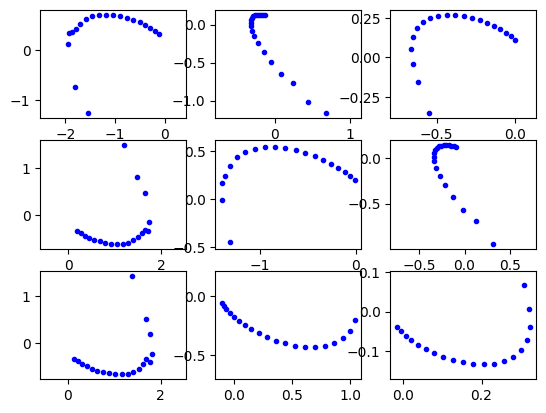

In [5]:
n = 2 if (n_demo < 9) else 3
fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        ax = axs[i][j]
        idx = (i*n) + j
        human_traj = np.array(robot_states_train[idx]).squeeze()
        ax.plot(human_traj[:,0],human_traj[:,1],'bo', markersize=3)
        ax.axis(xmin=-1, xmax=1, ymin=-1, ymax=1)
        ax.axis('equal')

### Visualize simulated human internal models

[array([[0.50231524]]), array([[0.]]), array([[1.]]), array([[0.]]), array([[0.05232362]]), array([[0.23411678]]), array([[0.43397309]]), array([[0.49187165]]), array([[0.53363921]]), array([[0.57931689]]), array([[0.62931689]]), array([[0.67931689]]), array([[0.72222378]]), array([[0.75357592]]), array([[0.76997711]]), array([[0.77121884]]), array([[0.7605582]]), array([[0.74368537]]), array([[0.72673747]]), array([[0.71442872]])]
[array([[0.89859944]]), array([[0.31141076]]), array([[0.93973407]]), array([[0.52906867]]), array([[0.46456236]]), array([[0.49706715]]), array([[0.50952651]]), array([[0.52731825]]), array([[0.54981492]]), array([[0.57719328]]), array([[0.60946296]]), array([[0.64636276]]), array([[0.68737791]]), array([[0.73180433]]), array([[0.77882981]]), array([[0.82882981]]), array([[0.87882981]]), array([[0.92882981]]), array([[0.97882981]]), array([[1.]])]
[array([[0.25726216]]), array([[0.7888272]]), array([[0.55193616]]), array([[0.53782123]]), array([[0.55545002]

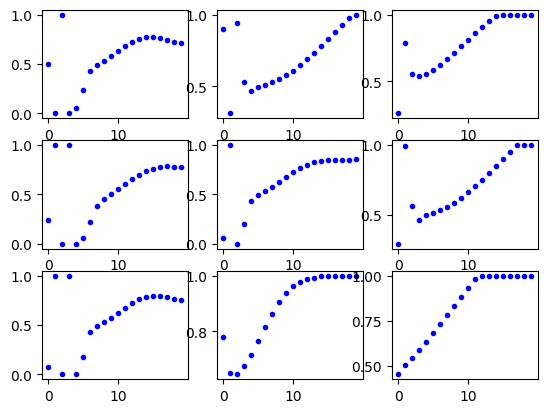

In [6]:
fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        ax = axs[i][j]
        idx = (i*n) + j
        print(human_mental_states_train[idx])
        human_internal_state_traj = np.array(human_mental_states_train[idx]).squeeze()
        ax.plot(human_internal_state_traj, 'bo', markersize=3)

### Pre-processing trajectory data for estimator

In [7]:
states_train = torch.tensor(robot_states_train, device=device)
states_train = states_train.view(train_size * sim_time, nX)
states_test = torch.tensor(robot_states_test, device=device)
states_test = states_test.view(test_size * sim_time, nX)

actions_train = torch.tensor(human_actions_train, device=device)
actions_train = actions_train.view(train_size * sim_time, nU)
actions_test = torch.tensor(human_actions_test, device=device)
actions_test = actions_test.view(test_size * sim_time, nU)

obs_train = torch.tensor(human_obs_train, device=device)
obs_train = obs_train.view(train_size * sim_time, nX)
obs_test = torch.tensor(human_obs_test, device=device)
obs_test = obs_test.view(test_size * sim_time, nX)

inputs_train = torch.cat((states_train, actions_train, obs_train), axis=1)
inputs_train = inputs_train.view(train_size, sim_time, nX + nU + nX).double()
inputs_test = torch.cat((states_test, actions_test, obs_test), axis=1)
inputs_test = inputs_test.view(test_size, sim_time, nX + nU + nX).double()

print('Train:', inputs_train.shape)
print('Test:', inputs_test.shape)

Train: torch.Size([350, 20, 5])
Test: torch.Size([150, 20, 5])


/var/folders/d3/1f2hz5r949s_skhpdxbyry2m0000gn/T/ipykernel_91136/244455849.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  states_train = torch.tensor(robot_states_train, device=device)


### Train $\theta_H$ estimator E2E with LQR

In [8]:
transformer_estimator = ThetaEstimatorTransformer().to(device).double()
optimizer = torch.optim.Adam(transformer_estimator.parameters(), lr=model_lr)

In [9]:
def predict_action(state, theta_H):
    B_hat_tensor = theta_H * torch.tensor([[0., ],[1.0]], device = device).double()
    P_hat = Riccati.apply(A_tensor, B_hat_tensor, Q_tensor, R_tensor)

    K = torch.linalg.multi_dot((
        torch.linalg.pinv(torch.add(
            R_tensor,
            torch.linalg.multi_dot((torch.transpose(B_hat_tensor, 0, 1), P_hat, B_hat_tensor))
        )),
        torch.transpose(B_hat_tensor, 0, 1),
        P_hat,
        A_tensor
    ))
    action_pred = -torch.matmul(K, state)
    return action_pred

def forward_pass(model, inputs, curr_traj_idx):
    inputs = inputs.reshape(-1, inputs.shape[0], inputs.shape[1])
    theta_Hs = model(inputs)
    theta_Hs = theta_Hs.reshape(sim_time)
    theta_H_error = 0

    step_losses = []
    for i in range(sim_time - 1):
        # theta_H = theta_Hs[i] * 0.0 + human_mental_states[curr_traj_idx][i][0][0]
        theta_H = theta_Hs[i]
        theta_H_true = human_mental_states_train[curr_traj_idx][i][0][0]
        theta_H_error += torch.linalg.norm(theta_H - theta_H_true).data.item()

        input = inputs[0][i]
        state, action, obs = torch.split(input, [2, 1, 2])
        
        action_pred = predict_action(state, theta_H)
        # print(action_pred, action)

        loss_fn = nn.MSELoss()
        loss = loss_fn(action_pred, action)

        if abs(loss) > 20:
            ipdb.set_trace()

        step_losses.append(loss)
    
    return step_losses, theta_H_error

def train_epoch(model, inputs):
    model.train()
    all_losses = []
    theta_H_error_all = 0
    for idx in range(inputs.shape[0]):
        inp = inputs[idx]
        step_losses, theta_H_error = forward_pass(model, inp, idx)
        theta_H_error_all += theta_H_error
        all_losses += step_losses
    
    optimizer.zero_grad()
    total_loss = sum(all_losses) / (sim_time * inputs.shape[0])
    total_loss.backward()
    optimizer.step()

    theta_H_error_all /= (sim_time * inputs.shape[0])

    return total_loss.data.item(), theta_H_error_all

def test_epoch(model, inputs):
    model.eval()
    all_losses = []
    theta_H_error_all = 0
    for idx in range(inputs.shape[0]):
        inp = inputs[idx]
        step_losses, theta_H_error = forward_pass(model, inp, idx)
        theta_H_error_all += theta_H_error
        all_losses += step_losses
    
    total_loss = sum(all_losses) / (sim_time * inputs.shape[0])
    theta_H_error_all /= (sim_time * inputs.shape[0])

    return total_loss.data.item(), theta_H_error_all

In [10]:
epoch_list = range(1, epochs+1)
train_losses, theta_H_train_errs, test_losses, theta_H_test_errs = [], [], [], []
for epoch in tqdm(epoch_list):
    # print(f'Epoch {epoch}: theta_H_error={theta_H_error}')
    train_loss, theta_H_train_err = train_epoch(transformer_estimator, inputs_train)
    test_loss, theta_H_test_err = test_epoch(transformer_estimator, inputs_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    theta_H_train_errs.append(theta_H_train_err)
    theta_H_test_errs.append(theta_H_test_err)

 31%|███       | 62/200 [47:47<30:43, 13.36s/it]    

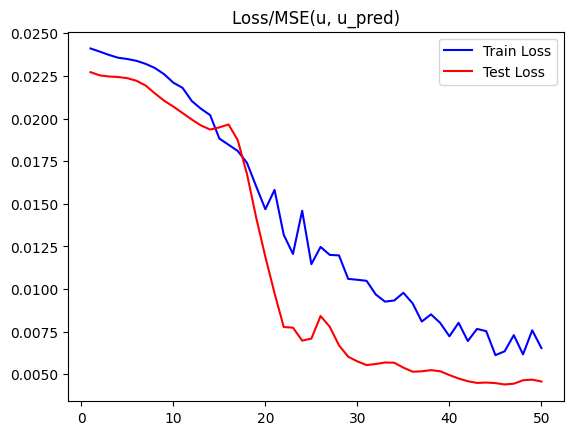

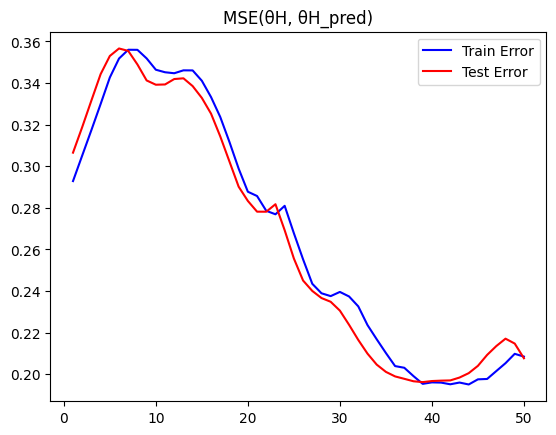

In [10]:
def loss_plot():
    plt.plot(epoch_list, train_losses, color='b', label='Train Loss')
    plt.plot(epoch_list, test_losses, color='r', label='Test Loss')
    plt.title('Loss/MSE(u, u_pred)')
    plt.legend()

def error_plot():
    plt.plot(epoch_list, theta_H_train_errs, color='b', label='Train Error')
    plt.plot(epoch_list, theta_H_test_errs, color='r', label='Test Error')
    plt.title('MSE(θH, θH_pred)')
    plt.legend()

loss_plot()
plt.show()
error_plot()
plt.show()

In [10]:
exp_name = 'varying_mental_varying_physical_large_eps'
exp_settings = {'sim_policy': sim_policy, 'sim_time': sim_time, 'n_demo': n_demo,
                'is_updating_internal_model': is_updating_internal_model,
                'stochastic_human': stochastic_human, 'human_lr': human_lr,
                'train_split': train_split, 'epochs': epochs, 'model_lr': model_lr}

folder_name = 'experiments/{}'.format(exp_name)
# assert not os.path.isdir(folder_name)
os.makedirs(folder_name)

with open(folder_name + '/settings.json', 'w') as f:
    json.dump(exp_settings, f)

loss_plot()
plt.savefig(folder_name + '/loss_plot.png')
plt.clf()
error_plot()
plt.savefig(folder_name + '/error_plot.png')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
# RL code similar to Assisted Perception paper
# increase n_demo to get MSE under 0.1 (and try training for more epochs)